In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys

In [39]:
con = lite.connect('./cyclus.sqlite')

In [40]:
con.row_factory = lite.Row
cur = con.cursor()

In [41]:
# unf composition
nucid_list = []
isos = cur.execute('SELECT distinct(nucid) FROM compositions').fetchall()
for i in isos:
    nucid_list.append(i['nucid'])
print(nucid_list)

[922350000, 922380000, 10010000, 10030000, 60140000, 340790000, 360850000, 380900000, 390900000, 400930000, 400950000, 410940000, 410950000, 430990000, 441030000, 441060000, 461070000, 471080001, 471100001, 501260000, 511240000, 511250000, 531290000, 551340000, 551350000, 551370000, 581440000, 611470000, 621510000, 631520000, 631540000, 631550000, 882260000, 892270000, 902290000, 902300000, 902320000, 912310000, 922320000, 922330000, 922340000, 922360000, 932370000, 942380000, 942390000, 942400000, 942410000, 942420000, 942440000, 952410000, 952420001, 952430000, 962420000, 962430000, 962440000, 962450000, 962460000, 962470000, 962480000, 982490000, 982510000]


In [42]:
iso_trans_dict = {}
for iso in nucid_list:
    mass_frac_list = []
    unf = cur.execute('SELECT time, massfrac FROM transactions '
                      'INNER JOIN resources ON '
                      'resources.resourceid = transactions.resourceid '
                      'INNER join compositions ON '
                      'compositions.qualid = resources.qualid '
                      'WHERE nucid = %s and commodity= "unf"' %str(iso)).fetchall()
    for row in unf:
        mass_frac_list.append(row['massfrac'])
    iso_trans_dict[iso] = mass_frac_list

In [43]:
iso_trans_dict.keys()

dict_keys([922350000, 922380000, 10010000, 10030000, 60140000, 340790000, 360850000, 380900000, 390900000, 400930000, 400950000, 410940000, 410950000, 430990000, 441030000, 441060000, 461070000, 471080001, 471100001, 501260000, 511240000, 511250000, 531290000, 551340000, 551350000, 551370000, 581440000, 611470000, 621510000, 631520000, 631540000, 631550000, 882260000, 892270000, 902290000, 902300000, 902320000, 912310000, 922320000, 922330000, 922340000, 922360000, 932370000, 942380000, 942390000, 942400000, 942410000, 942420000, 942440000, 952410000, 952420001, 952430000, 962420000, 962430000, 962440000, 962450000, 962460000, 962470000, 962480000, 982490000, 982510000])

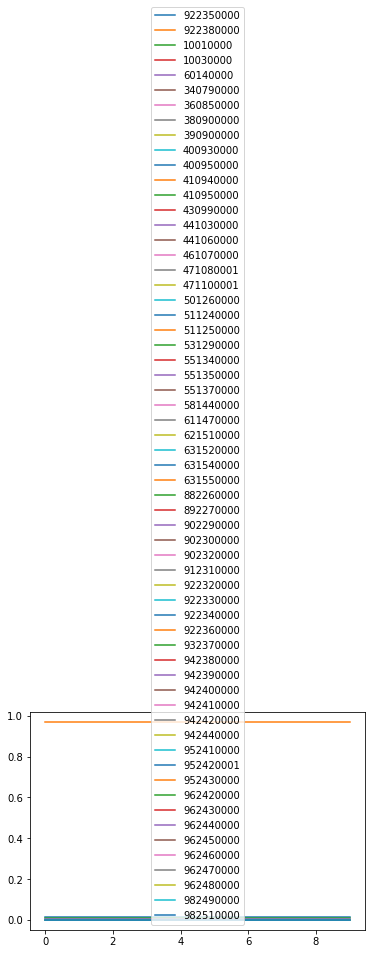

In [44]:
for key, val in iso_trans_dict.items():
    plt.plot(val, label=key)

plt.legend()
plt.show()


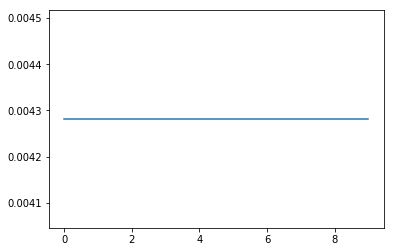

In [45]:
plt.plot(iso_trans_dict[942390000])

In [46]:
# input fuel enrichment
# unf composition
iso_trans_dict = {}
for iso in [922350000, 922380000]:
    mass_frac_list = []
    unf = cur.execute('SELECT time, massfrac FROM transactions '
                      'INNER JOIN resources ON '
                      'resources.resourceid = transactions.resourceid '
                      'INNER join compositions ON '
                      'compositions.qualid = resources.qualid '
                      'WHERE nucid = %s and commodity= "fuel"' %str(iso)).fetchall()
    for row in unf:
        mass_frac_list.append(row['massfrac'])
    iso_trans_dict[iso] = mass_frac_list

In [47]:
print(iso_trans_dict)

{922350000: [0.025, 0.032, 0.019999999999999997, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032], 922380000: [0.9750000000000001, 0.968, 0.98, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968]}


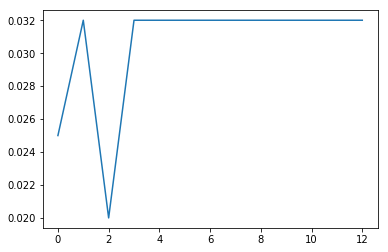

In [48]:
plt.plot(iso_trans_dict[922350000])